In [ ]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
learning_rate = 0.001
batch_size    = 100
N_epochs      = 20
N_iter_train  = 250
N_iter_test   = 40
N_iter_check  = 5
input_size    = 10

hidden_size   = 10

In [ ]:
def sequence_generator(L,batch_size,K = 1): #K=1, the model has to remember value at 2nd position
    
    random_seq = np.random.randint(0, 9,(batch_size, L)) #generated random number sequence

    x = np.zeros((batch_size,L,10)) #second dimension is 10 as we're looking at one-hot vectors
    y = np.zeros((batch_size,10)) #output
    
    for i in range(batch_size):
        x[i,np.arange(L), random_seq[i]] = 1
        y[i,random_seq[i,K]] = 1
        
    #converting to torch    
    random_seq = torch.tensor(random_seq, dtype=torch.float) 
    x = torch.tensor(x, dtype=torch.int)
    y = torch.tensor(y, dtype=torch.float)
    

    return random_seq,x.float(),y #as input x is reqd to be float 

In [ ]:
class vanilla_RNN(nn.Module):
    def __init__(self,hidden_size):
        
        super().__init__()

        self.rnn = nn.RNN(input_size = 10, 
                          hidden_size = hidden_size, 
                          num_layers = 1,
                          bidirectional = False, 
                          batch_first = True)       
        self.fc = nn.Linear(hidden_size, 10)
        
    def forward(self, x):

        output, hidden = self.rnn(x)
        out = self.fc(output[:,-1,:]) 
           
        return out

In [ ]:
from torch import optim
loss_func = nn.CrossEntropyLoss()
model = vanilla_RNN(hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
def Train_sequence(model,optimizer,loss_func,N_iter_train = 250):
    
    model.train() #setting the model in training mode
    #initializing the total training loss and total correct training predictions to 0
    train_loss    = 0
    train_correct = 0 #correct predictions made
    
    train_length = batch_size*N_iter_train
    
    for i in range(N_iter_train):
        
        L = np.random.randint(3,10) #randomizing L
        
        random_seq,x,y = sequence_generator(L)
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x) #prediction using the input data
      
        loss = loss_func(pred,y)
        
        optimizer.zero_grad() #zeroing out the gradients before backprop
        loss.backward()       #backprop from the loss
        optimizer.step()      #updating the weights
        
        pred = pred.cpu()
        loss = loss.cpu()

        #Adding this loss to  training loss and computing correct predictions
        train_loss    += loss
        train_correct += (np.asarray(pred.argmax(axis = 1)-y.cpu().argmax(axis = 1))==0).sum() #as subtraction will result in 0 for correct pred
        
    #Computing training accuracy 
    train_loss = train_loss/(i+1)
    train_correct /= train_length #training accuracy 
    
    return train_loss.detach().cpu().numpy(), train_correct #returning loss and accuracy 

In [ ]:
def Test_sequence(model,loss_func,N_iter_test = N_iter_test):
    
    model.eval()  #setting the model in eval/test mode
    
    #initializing the total test loss and total correct test predictions to 0
    test_loss    = 0
    test_correct = 0 #correct predictions made
    test_length = batch_size*N_iter_test
    
    #switching off the gradient for eval
    with torch.no_grad():
        
        for i in range(N_iter_test):
        
            L = np.random.randint(3,10) #randomizing L
        
            random_seq,x,y = sequence_generator(L)
            x = x.to(device)
            y = y.to(device)
        
            pred = model(x) #prediction using the input data
        
            loss = loss_func(pred,y.argmax(axis = 1))
            
            pred = pred.cpu()
            loss = loss.cpu()

            #Adding this loss to  testing loss and computing correct predictions
            test_loss    += loss
            test_correct += (np.asarray(pred.argmax(axis = 1)-y.cpu().argmax(axis = 1))==0).sum() #as subtraction will result in 0 for correct pred
        
    #Computing prediction accuracy 
    test_loss = test_loss/(i+1)
    test_correct /= test_length #prediction accuracy 
    
    return test_loss.detach().cpu().numpy(), test_correct #returning loss and accuracy 

1 / 20
Train loss for Epoch  1 :  2.2575984  |  Train accuracy for Epoch  1 :  0.12164
Test loss for Epoch  1 :  2.2061765  |  Test accuracy for Epoch  1 :  0.131
2 / 20
Train loss for Epoch  2 :  2.1297002  |  Train accuracy for Epoch  2 :  0.17872
Test loss for Epoch  2 :  2.0904086  |  Test accuracy for Epoch  2 :  0.20575
3 / 20
Train loss for Epoch  3 :  2.0817266  |  Train accuracy for Epoch  3 :  0.20388
Test loss for Epoch  3 :  2.0877497  |  Test accuracy for Epoch  3 :  0.199
4 / 20
Train loss for Epoch  4 :  2.0503883  |  Train accuracy for Epoch  4 :  0.2298
Test loss for Epoch  4 :  2.0093217  |  Test accuracy for Epoch  4 :  0.24225
5 / 20
Train loss for Epoch  5 :  1.9422538  |  Train accuracy for Epoch  5 :  0.272
Test loss for Epoch  5 :  1.847606  |  Test accuracy for Epoch  5 :  0.30725
6 / 20
Train loss for Epoch  6 :  1.6689517  |  Train accuracy for Epoch  6 :  0.34336
Test loss for Epoch  6 :  1.5011898  |  Test accuracy for Epoch  6 :  0.38525
7 / 20
Train loss 

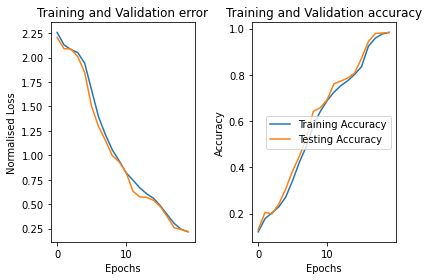

In [ ]:
#initialising the lists
train_losses   = []
test_losses    = []
train_accuracy = []
test_accuracy  = []

#for epoch in range(1, N_epochs+1):
for epoch in range(1, N_epochs+1):
    print(epoch,"/", N_epochs)

    #train the model
    loss,accuracy = Train_sequence(model,optimizer,loss_func,N_iter_train = N_iter_train)
    train_losses.append(loss)
    train_accuracy.append(accuracy)
    print('Train loss for Epoch ',epoch,': ',loss,' | ', 'Train accuracy for Epoch ',epoch, ': ',accuracy)

    #test the model
    loss,accuracy = Test_sequence(model,loss_func,N_iter_test = N_iter_test)
    test_losses.append(loss)
    test_accuracy.append(accuracy)
    print('Test loss for Epoch ',epoch,': ',loss, ' | ', 'Test accuracy for Epoch ',epoch, ': ',accuracy)

#Plotting the Loss and the accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.asfarray(train_losses),label = 'Train Loss') #converting to float array
ax1.plot(np.asfarray(test_losses),label = 'Validation Loss') 
ax1.set(xlabel='Epochs', ylabel='Normalised Loss')
ax1.set_title('Training and Validation error')

ax2.plot(np.asfarray(train_accuracy),label = 'Training Accuracy')
ax2.plot(np.asfarray(test_accuracy),label = 'Testing Accuracy')
ax2.set(xlabel='Epochs', ylabel='Accuracy')
ax2.set_title('Training and Validation accuracy')
ax2.legend()
fig.tight_layout()

In [ ]:
def Check_sequence(model,lossfn,N_iter_check):
    
    model.eval()
    
    test_accuracies = []
    
    for L in range(3,10): #iterating through L in the required range
    
        #initializing the total test loss and total correct test predictions to 0
        test_loss    = 0
        test_correct = 0 #correct predictions made
        test_length = N_iter_check
    
        #switching off the gradient for eval
        with torch.no_grad():
            
        
            random_seq,x,y = sequence_generator(L,N_iter_check)
            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss = loss_func(pred,y.argmax(axis = 1))
            
            pred = pred.cpu()
            loss = loss.cpu()
    
            #Adding this loss to  testing loss and computing correct predictions
            test_loss    += loss
            test_correct += (np.asarray(pred.argmax(axis = 1)-y.cpu().argmax(axis = 1))==0).sum() #as subtraction will result in 0 for correct pred
        
        #Computing prediction accuracy 
    
        test_correct /= test_length #prediction accuracy
            
        test_accuracies.append(test_correct)
            
    
    #plotting test accuracies vs L
    
    plt.bar(np.arange(3,10),test_accuracies)
    plt.xlabel('L')
    plt.ylabel('Accuracy')
    plt.ylim(0,1) #as accuracy is between 0 and 1
    plt.grid()
    plt.legend()
    plt.title('Prediction Accuracy vs Length')
    plt.show()
    
    print(f'Prediction Accuracies : {test_accuracies}')

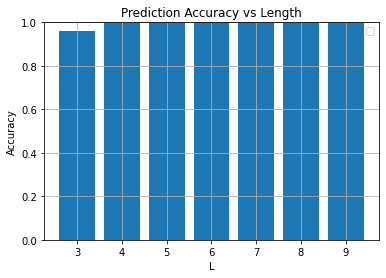

Prediction Accuracies : [0.96, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
Check_sequence(model,loss_func,100)